Dataset dapat dilihat di https://www.kaggle.com/rahulanand0070/youtubevideodataset

In [1]:
import os
import zipfile
local_zip = '/content/youtubecategory.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [23]:
import pandas as pd
df = pd.read_csv('Youtube_Video_Dataset.csv')
df

,Title,Videourl,Category,Description
0,Madagascar Street Food!!! Super RARE Malagasy ...,/watch?v=EwBA1fOQ96c,Food,🎥GIANT ALIEN SNAIL IN JAPAN! » https://youtu.b...
1,42 Foods You Need To Eat Before You Die,/watch?v=0SPwwpruGIA,Food,This is the ultimate must-try food bucket list...
2,Gordon Ramsay’s Top 5 Indian Dishes,/watch?v=upfu5nQB2ks,Food,We found 5 of the best and most interesting In...
3,How To Use Chopsticks - In About A Minute 🍜,/watch?v=xFRzzSF_6gk,Food,You're most likely sitting in a restaurant wit...
4,Trying Indian Food 1st Time!,/watch?v=K79bXtaRwcM,Food,HELP SUPPORT SINSTV!! Shop Our Sponsors!\nLast...
...,...,...,...,...
11206,"art journal | shimmer sprays, stencils, collag...",/watch?v=mJBOQr_-8_Y,Art&Music,Step by step video on creating an art journal ...
11207,Ar-Tea Collage * Mixed Media Art,/watch?v=GOihUhnZxtw,Art&Music,"By: Ilene McInnes,\nMixed media Art and inspir..."
11208,DIY Mixed Media Art Collage Greeting Cards / M...,/watch?v=BchUtLfjews,Art&Music,Make your own Mixed Media Greeting Cards\n\nHe...
11209,Art Collage Process DecoJournal using Rice Pap...,/watch?v=FlQ_j-cflQc,Art&Music,Art Collage Process DecoJournal using Rice Pap...


Description tidak dibutuhkan karena banyak isinya tidak berhubungan sama sekali dengan konten (seperti iklan untuk konten lain dsb) sehingga yang akan digunakan hanyalah Title sebagai feature dan Category sebagai label

In [3]:
df = df.drop(columns=['Videourl', 'Description'])
df.head()

,Title,Category
0,Madagascar Street Food!!! Super RARE Malagasy ...,Food
1,42 Foods You Need To Eat Before You Die,Food
2,Gordon Ramsay’s Top 5 Indian Dishes,Food
3,How To Use Chopsticks - In About A Minute 🍜,Food
4,Trying Indian Food 1st Time!,Food


In [46]:
category = pd.get_dummies(df.Category)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='Category')
df_baru.head()

,Title,Videourl,Description,Art&Music,Food,History,Science&Technology,manufacturing,travel blog
0,Madagascar Street Food!!! Super RARE Malagasy ...,/watch?v=EwBA1fOQ96c,🎥GIANT ALIEN SNAIL IN JAPAN! » https://youtu.b...,0,1,0,0,0,0
1,42 Foods You Need To Eat Before You Die,/watch?v=0SPwwpruGIA,This is the ultimate must-try food bucket list...,0,1,0,0,0,0
2,Gordon Ramsay’s Top 5 Indian Dishes,/watch?v=upfu5nQB2ks,We found 5 of the best and most interesting In...,0,1,0,0,0,0
3,How To Use Chopsticks - In About A Minute 🍜,/watch?v=xFRzzSF_6gk,You're most likely sitting in a restaurant wit...,0,1,0,0,0,0
4,Trying Indian Food 1st Time!,/watch?v=K79bXtaRwcM,HELP SUPPORT SINSTV!! Shop Our Sponsors!\nLast...,0,1,0,0,0,0


In [47]:
df_baru.shape

(11211, 9)

In [5]:
judul = df_baru['Title'].values
label = df_baru[['Art&Music', 'Food', 'History', 'Science&Technology', 'manufacturing', 'travel blog']].values

In [6]:
from sklearn.model_selection import train_test_split
judul_latih, judul_test, label_latih, label_test = train_test_split(judul, label, test_size=0.2)

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(judul_latih) 
tokenizer.fit_on_texts(judul_test)
 
sekuens_latih = tokenizer.texts_to_sequences(judul_latih)
sekuens_test = tokenizer.texts_to_sequences(judul_test)
 
padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

In [41]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    # Menggunakan Neuron yang sedikit 
    # Karena Neuron yang besar pada model ini menyebabkan overfitting
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 16)          80000     
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                6272      
_________________________________________________________________
dense_21 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 6)                 198       
Total params: 87,526
Trainable params: 87,526
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Penggunaan Callback mencegah overfitting dan menghentikan training setelah akurasi terpenuhi
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92):
      print("\nAkurasi di atas 92%, hentikan pelatihan!")
      self.model.stop_training = True

callbacks = myCallback()

In [42]:
num_epochs = 10
history = model.fit(padded_latih, label_latih, epochs=num_epochs, 
                    validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks])

Epoch 1/10
281/281 - 3s - loss: 1.2618 - accuracy: 0.4871 - val_loss: 0.4358 - val_accuracy: 0.8908
Epoch 2/10
281/281 - 3s - loss: 0.3984 - accuracy: 0.8833 - val_loss: 0.2362 - val_accuracy: 0.9211
Epoch 3/10

Akurasi di atas 92%, hentikan pelatihan!
281/281 - 3s - loss: 0.2207 - accuracy: 0.9371 - val_loss: 0.2177 - val_accuracy: 0.9291


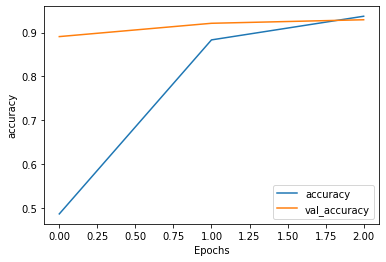

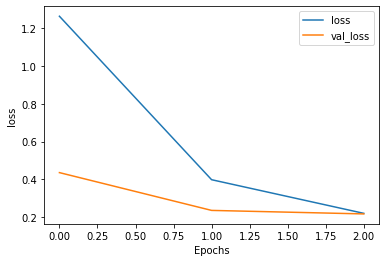

In [43]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")